# Domain Specific Code Generation using the FormLang DSL

#### Motivation

AI and LLM systems are being trained to perform a variety of complex tasks requiring expertise in many software tools, languages and technology stacks. Some of the challenges in this industry are purely technical and cost related, for example quality data acquisition in high volumes and the high compute costs associated with hosting very large models. On the other hand, businesses and individual AI users are increasingly required to cope with or at least be aware of the inherent Data Privacy and Intellctual Property concerns that arise with the usage of 3rd party cloud services. These 3rd parties in some cases provide the infrastructure (for training and inference) and in other cases (such as ChatGPT and Gemini) completely own the models and may utilize sensitive business data to improve their models.

I hypothesize that by leveraging model fine-tuning, it is possible in many cases to address these concerns (both cost-related as well as privacy and IP-related) by utilizing smaller LLMs which can operate "offline" - in the sense that no cloud or 3rd party provider is needed for their training and that inference can be run on end-user devices such as consumer CPUs.

#### The use case

As a Fullstack Developer I am often tasked with creating new web-forms and interfaces that handle user data input and submission. These forms and interfaces share much of their common functionality and coding patterns. For example, when implemeting Frontend state management and validation a development team adheres to common coding patterns and uses the same libraries, while for the UI design a certain set of components and styles are resued (also known as a "Design system").

While AI applications like ChatGpt and Gemini often produce good code, it is difficult to have them write code according to our exact patterns and styles, and providing them with the full context of our codebase is not only challenging but also concerning from an IP protection perspective.

#### The methodology

My proposed approach is to try to decouple the "What" of coding web-forms from the "How", with the goal of having the LLM master the "What" and deferring the "How" to a deterministic compiler or transpiler program which can be configured to output code according to our requirements.  

To do so I created a Domain Specific Language (DSL) called "FormLang" which allows a developer to express the structure and state of web-forms using a high level formal language, with a compiler in the backend that translates it to actual code implementation.

The challenge is therefore, to train a model to reliably generate code in this a new language given a user query in natural language, a task generally known as "Semantic Parsing".

#### Project goals

In this project I do not attempt to create a full working system but rather to train a small (1B parameter) Instruction-tuned LLM to generate code completions in FormLang given some input code and instructions on how to complete it. Since this is a new language with no prior user generated data in existence, I try to synthetically generate a dataset of instructions and answers to train on.

If this method is successful, it could justify further research and perhaps be adapted to other domains.

#### Code

The official repository of this project is hosted in GitHub at https://github.com/guyo13/Form-Lang.


# Dataset generation

## Generating synthetic FormLang code

### The structure of the language

The FormLang language is composed of the following entities:

* A `field` which describes an input element where users are expected to input data.
* A `form` which acts as a UI and state container of a collection of related `field`'s. `form`'s can be nested, containing other forms to enable encapsulation of complex UI's.
* A third entity named `component`, serves as a binding between the language and the users' component libraries (or design systems).

The grammar rules are quite simple:

1. Each of the three entities are identified by alphanumeric id's and any `form` or `field` declarations must also contain the id of the `component` that should be displayed when the form is rendered.
2. A `field` may declare a state using the `state` keyword and can define its data type (currently either a `string`, `number` or `boolean`). The state can be defined as an array of the declared datatype and can also declare a default value, which can be either a string or an expression in the target language (for example Javascript or Typescript).
3. Only `form` or `component` declarations can appear at the top level of the document, `field` are always declared inside a parent `form`. `forms` can also be children of other `form`s.



### Creating a probabilistic form generator

Using the above rules I modelled the data generation problem as a tree search-like algorithm that starts at the root of a generated `form` and traverses depth-first where each decendant node is either a nested `form` or a `field` whose properties and structure are controlled by a parametric probabilisitic model.   

The result of this approach is the `ProbabilisticSearchFormGenerator` ([link](https://github.com/guyo13/Form-Lang/blob/main/src/generation/formGen.ts#L102)) class implemeting this algorithm in Typescript.

The use of Typescript and Javascript in this project is a technical constraint given the fact that the language was created using the [Langium](https://langium.org/) toolkit which works with Typescript.

#### Algorihm pseudo code:

**Algorithm `generateForm`**

**Parameters:** ($0 \leq \alpha < 1$, $0 \leq \beta < 1$, $0 \leq \gamma < 1$, $0 \leq \delta < 1$, $0 \leq \epsilon < 1$, $D \in \mathbb{N}$,
$maxChildren \in \mathbb{N}$, $amax \in \mathbb{N}$)

* Iterate Depth-First, start with an empty form definition.
* For each item off the frontier if the item is a Field, append it to its Parent Form.
* If the item is a Form, generate its children and add them onto the frontier. Generate children according to the following rules:
    * Assign the `depth` property to the child node: $depth = parentDepth + 1$.
    * At a probability of   p =  \begin{cases} \alpha^{depth} & \text{if } depth < D \\ 0 & \text{otherwise} \end{cases}, the type of the child will be a `form`, and $1 - p$ for a `field`.
    * The number of generated children is a random number in the range of $[0, maxChildren]$.
    * If the child is a `field`, at a probability of $\beta$ it will contain a `state`.
      * At a probability of $\gamma$ that a state definition will be an `array`.
        * The number of array elements will be chosen at random from the integer interval $[0, amax]$.
      * There is an equal probability of the state `type` to be any of the supported built-in types.
      * There is a probability of $\delta$ that a state definition will contain a `default` value.
        * If the `type` is `string` there is an $\epsilon$ probability of the default value to be defined as `as expression`, otherwise the probability is $1$.
* For each item off the frontier chose a random component from a set of available components.
  * Choose at random the number of assigned component props from the range $[0, ComponentPropCount]$.
    * For each assigned prop generate a random value with $\epsilon$ probability of the value to be defined as `as expression`

The algorithm ranomly generates the tree structure of the form which is then serialized into `FormLang` source code.



#### Hyper parameter selection

Some of the main advatages of using probabilistic search is the simplicity of implementation as well as the ability to create datasets representing different distributions by adjusting the generation hyper parameters.

On the other hand, this is also the biggest issue with the algorithm because now we have to employ some method of hyperparameters selection.

This issue is compounded by the fact that no prior user-data exist in the language

This hyperparameter selection suffers from the fact that different domains and use-cases may require differently structured forms and so a single hyperparameter set is unlikely to fit all use-cases.

I tried to look at the literature for synthetic data generation processes for semantic parsing and found two interesting papers:

1. Bailin Wang et al. [Learning to Synthesize Data for Semantic Parsing](https://aclanthology.org/2021.naacl-main.220.pdf). The researchers learned a PCFG (Probabilistic Context-Free Grammar) model of the SQL language which was used to generate utterance-SQL pairs. However contrary to their approach that relied on existing and representative utterance-SQL pairs, with FormLang no prior user-data exist and so a PCFG parameters can't be learned.

2. Qian Liu et al. [TAPEX - Table Pre-training via Learning a Neural SQL Executor](https://table-pretraining.github.io/), used SQL templates extracted from the SQUALL dataset, from which synthetic queries were automatically generated. This approach is less similar to my parameterized approach.

Failling to find a definitive answer I came up with my own approach:

1. I discretized all the continuous hyperparameters using a step size of 0.1 and set a hard-limit of 4 to the integer hyperparameters (mostly to avoid excessive form nesting which make little sense in most real-world scenarios).

2. Using these constraints I randomly sampled a 1000 unique sets of hyperparameters.

3. For each set of hyperparameters I generated 100 random forms using the hyperparameter set.

4. In total around 100K different examples were generated, equally representing 1000 different distributions. (around 26 examples were found to be duplicates and discarded later in the process).

##### Generating 1000 unique hyperparameter sets

In [70]:
import random
import pandas as pd

def generate_random_permutations(num_permutations=10, seed=None):
    """Generates random permutations of the probabilisticSearchParamsSchema without duplicates."""

    probability_values = [i / 10 for i in range(10)]
    integer_values = list(range(5))
    if seed is not None:
        random.seed(seed)

    permutations = set() # Use a set to store unique permutations
    while len(permutations) < num_permutations:
        permutation = {
            "alpha": random.choice(probability_values),
            "beta": random.choice(probability_values),
            "gamma": random.choice(probability_values),
            "delta": random.choice(probability_values),
            "epsilon": random.choice(probability_values),
            "zeta": random.choice(probability_values),
            "D": random.choice(integer_values[1:]), # make sure D is always positive
            "maxChildren": random.choice(integer_values[1:]), # make sure maxChildren is always positive
            "amax": random.choice(integer_values),
        }

        # Convert the dictionary to a tuple of tuples for set hashing
        permutation_tuple = tuple(sorted(permutation.items()))
        permutations.add(permutation_tuple)

    # Convert the set of tuples back to a list of dictionaries
    permutation_list = [dict(item) for item in permutations]

    return pd.DataFrame(permutation_list)

In [71]:
hyper_param_set = generate_random_permutations(1000, seed=42)
hyper_param_set

,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta
0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7
1,3,0.7,2,0.0,0.8,0.4,0.1,2,0.0
2,1,0.8,2,0.7,0.3,0.9,0.3,1,0.5
3,1,0.7,1,0.9,0.4,0.8,0.7,4,0.0
4,1,0.6,2,0.4,0.3,0.9,0.0,4,0.1
...,...,...,...,...,...,...,...,...,...
995,1,0.8,2,0.7,0.3,0.4,0.2,1,0.3
996,2,0.8,2,0.6,0.8,0.7,0.3,3,0.8
997,3,0.8,0,0.3,0.8,0.2,0.9,4,0.2
998,1,0.5,1,0.7,0.3,0.2,0.5,2,0.6


##### Visualizing the generated hyperparameters

I used histograms for visualizing the integer hyperparameters and boxplots for the probability hyperparameters.

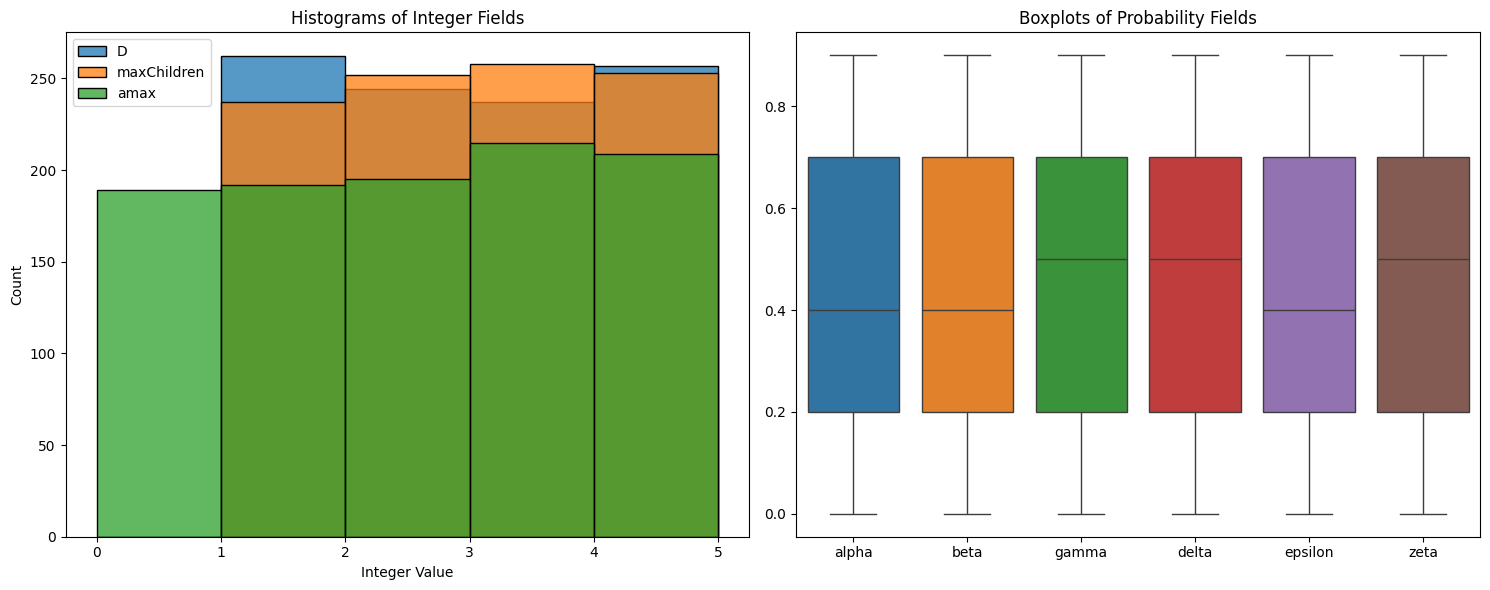

In [72]:
visualize_data(hyper_param_set)

### Generating the 100K examples

#### Creating hard coded `component` definitions

As explained in the previous sections, FormLang code consists of `form`, `field` and `component` definitions. For the case of generating code completions I was more interested in the LLM generating the correct `form` and `fields` while `components` are of lesser interest because they are simply binding code.

For this reason and for project time constraints, all of the instruction-answer pairs in our dataset uses the same `component` definitions. I manually created some definitions which each of the 100K dataset examples are randomly sampling from.

In [73]:
form_components = """
  component userDetailsContainer {}
  component formContainer {}
  component someOtherContainer {}
  component OtherContainer2 {}
  component Grid {}
  component Table {}
"""
field_components = """
  component myTextBox {
    props {
      textColor
      textSize
      textWeight
      borderColor
    }
  }
  component myCheckbox {
    props {
      size
    }
  }
  component otherTextBox {}
  component counter {
    props {
      style
    }
  }
  component mySelect {
    props {
      options
    }
  }
  component myRadio {
    props {
      options
    }
  }
  component myButton {
    props {
      text
    }
  }
  component myTextArea {
    props {
      rows
      cols
    }
  }
"""

#### Creating the instruction-answer pairs

1. For each example in the dataset we being by generating a random root `form` using the example's set of hyperparameters.
2. This `form`'s code is used as the expected answer in our instruction-answer example.
3. In order to generate the instruction part we omit at random one of the `form`'s descendant nodes (which can be either a `field` or a nested `form`).
4. We then create an English description of the ommited node along with a description of its surrounding context in the form, which includes a description of its siblings (if present) and its parent node.

The algorithm returns the original form code, the modified code as well as the English descriptions.

The algorithm is implemented in Typescript and I call it from the Python code by running an HTTP server with a REST API that accepts the hyperparameters and the count of examples to generate and returns the generated data. (See Appendix A for the client code that invokes this API).

For each generated example we also compute the original form code AST (although it is later re-computed during evaluation steps during training).

The below `create_random_data` function accepts a DataFrame of hyperparameters sets and a number of examples to generate and calls the REST API for generating the examples. The rest of the functions take care of parsing the API response and returning a dict per example with all the relevant data.

For each generated example, I saved the hyperparameters used to generate it along with the example.

I used multiprocessing in order to parallelize the API calls and expedite the generation process. The output is an `examples` DataFrame containing all the generated examples.

In [74]:
import time
import pandas as pd
import concurrent.futures
import os
from tqdm import tqdm

def concat_components_code_with_form_code(form_code, form_components, field_components):
    """Concatenates the form code with the given components code that are referenced inside of it."""
    return f"{form_components}\n{field_components}\n{form_code}"

def create_prompt_data(generation_result, form_components, field_components):
    data = {
        "originalFormCode": concat_components_code_with_form_code(generation_result["serializedForm"], form_components, field_components),
        "modifiedFormCode": concat_components_code_with_form_code(generation_result["serializedModifiedForm"], form_components, field_components),
        "removedNodeEnglish": str(generation_result["removedNodeEnglish"]),
        "removedNodeContextEnglish": str(generation_result["removedNodeContextEnglish"]),
    }
    return data

def generate_and_process_hyperparams(hyperparams, examples_per_hyperparam, form_components, field_components):
    response = generate_random_forms(examples_per_hyperparam, form_components, field_components, hyperparams)
    if response is None:
        raise ValueError("Didnt generate any data")
    local_data = []
    for ex in response:
        prompt_data = create_prompt_data(ex, form_components, field_components)
        prompt_data = {**prompt_data, **hyperparams}
        local_data.append(prompt_data)
    return local_data

def process_example(example):
    resp = get_ast(example["originalFormCode"], True)
    errors = resp.get('errors', [])
    if len(errors) > 0:
        print(f"Error parsing generated code", errors)
        raise RuntimeError("Error parsing generated code")
    example["originalFormAst"] = resp["ast"]
    return example

def create_random_data(hyper_param_set, form_components, field_components, num_examples=100000):
    start_time = time.time()
    DATA = []
    n_hyperparams = len(hyper_param_set)
    examples_per_hyperparam = num_examples // n_hyperparams

    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(tqdm(
            executor.map(generate_and_process_hyperparams,
                         list(map(lambda x: x._asdict(), hyper_param_set.itertuples())),
                          [examples_per_hyperparam] * n_hyperparams, [form_components] * n_hyperparams, [field_components] * n_hyperparams),
            total=n_hyperparams, desc="Generating Forms using Hyperparams", unit="hyperparam set"
        ))

    for result in results:
        DATA.extend(result)

    ast_time = time.time()

    with concurrent.futures.ProcessPoolExecutor() as executor:
        DATA = list(tqdm(executor.map(process_example, DATA), total=len(DATA), desc="Generating ASTs"))

    end_time = time.time()

    # Create the DataFrame after all processing is done
    df = pd.DataFrame(DATA)
    print(f"Generation took {end_time - start_time} seconds. Total Ast generation time {end_time - ast_time} seconds")
    return df

In [82]:
%%time

examples = create_random_data(hyper_param_set, form_components, field_components, num_examples=100000)
examples.head()

Generating ASTs: 100%|██████████| 100000/100000 [04:14<00:00, 393.43it/s]


Generation took 272.2172021865845 seconds. Total Ast generation time 261.09270572662354 seconds
CPU times: user 40.5 s, sys: 11.1 s, total: 51.6 s
Wall time: 4min 33s


,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,Index,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta,originalFormAst
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'gw' with state of type:...,* is a child of the form whose id is 'Jww'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""Jww"",""component"":{""$ty..."
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta field whose id is 'Q' with state of type...,* is a child of the form whose id is 'hw'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""v"",""component"":{""$type..."
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Yw_w' with state of typ...,* is a child of the form whose id is 'q'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""q"",""component"":{""$type..."
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'Sw_' with state of type...,* is a child of the form whose id is 'H_'.\n* ...,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""H_"",""component"":{""$typ..."
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\ta field whose id is 'c' with state of type: ...,* is a child of the form whose id is 'aw_w'.,0,4,0.2,1,0.8,0.5,0.6,0.4,2,0.7,"{""$type"":""Form"",""name"":""aw_w"",""component"":{""$t..."


##### Visualizing the distribution

In order to visually validate the generation process I plotted again the hyperparameters distributions, this time over the `examples` DataFrame to make sure we observe the same plots as in the previous section.

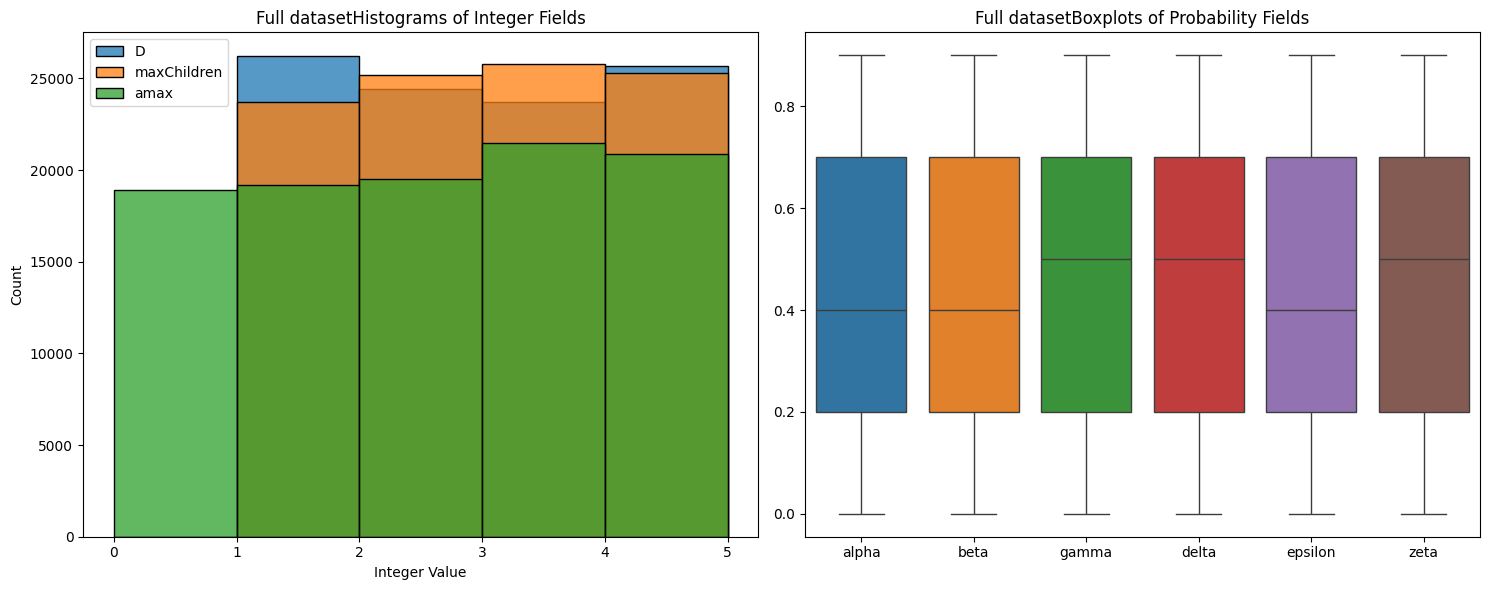

In [83]:
visualize_data(examples, title_prefix="Full dataset")

##### Example generated FormLang code

To visualize the omission algorithm I picked a random example and display a side-by-side diff of the origin code and the modified code.

In [192]:
side_by_side_diff(examples["originalFormCode"][1132], examples['modifiedFormCode'][1132])

f,1,,f,1,
,2,component userDetailsContainer {},,2,component userDetailsContainer {}
,3,component formContainer {},,3,component formContainer {}
,4,component someOtherContainer {},,4,component someOtherContainer {}
,5,component OtherContainer2 {},,5,component OtherContainer2 {}
,6,component Grid {},,6,component Grid {}
,7,component Table {},,7,component Table {}
,8,,,8,
,9,,,9,
,10,component myTextBox {,,10,component myTextBox {
,11,props {,,11,props {


#### Creating the user prompts

For each example in our synthetic dataset, we create the user prompt which will be appended to the instruction part of each example prompt.

The user prompt consists of the modified FormLang code taken from each of our dataset examples along with the english description of the required form completion as well as its generated context description in the form.

This template is applied to all examples in the dataset.

In [193]:
def create_prompt(row):
    return (
            "```FormLang\n"
            f"{row['modifiedFormCode']}\n"
            "```\n"
            "The description of the form element you need to add:\n"
            f"{row['removedNodeEnglish']}\n"
            "The description of the context in the form where you should add the element:\n"
            f"The element to be added:\n{row['removedNodeContextEnglish']}\n"
           )

In [194]:
%%time

examples["userPrompt"] = examples.apply(create_prompt, axis=1)
examples.head()

CPU times: user 835 ms, sys: 7.14 ms, total: 842 ms
Wall time: 840 ms


,originalFormCode,modifiedFormCode,removedNodeEnglish,removedNodeContextEnglish,Index,D,alpha,amax,beta,delta,epsilon,gamma,maxChildren,zeta,originalFormAst,userPrompt
0,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'Nw_w_ww' with state...,* is a child of the form whose id is 'aw'.\n* ...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""h"",""component"":{""$type...",```FormLang\n\n component userDetailsContaine...
1,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\ta form whose id is 'O' using the component...,* is a child of the form whose id is 'Kw'.,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""Fw"",""component"":{""$typ...",```FormLang\n\n component userDetailsContaine...
2,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'Y_www__ww__www_ww_w...,* is a child of the form whose id is 'ow'.\n* ...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""M"",""component"":{""$type...",```FormLang\n\n component userDetailsContaine...
3,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'K_' using the compo...,* is a child of the form whose id is 'Jw'.\n* ...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""T"",""component"":{""$type...",```FormLang\n\n component userDetailsContaine...
4,\n component userDetailsContainer {}\n compo...,\n component userDetailsContainer {}\n compo...,\t\t\ta field whose id is 'Lw' with state of t...,* is a child of the form whose id is 'v'.\n* i...,0,3,0.9,4,0.2,0.3,0.0,0.3,3,0.9,"{""$type"":""Form"",""name"":""S_ww___w_w___ww_"",""com...",```FormLang\n\n component userDetailsContaine...


##### Example User Prompt vs. Modified Code

Once again I plot a side-by-side diff to illustrate the formatted user prompt vs. the raw modified form code.

In [195]:
side_by_side_diff(examples["modifiedFormCode"][1132], examples['userPrompt'][1132])

n,,,n,1,```FormLang
,1,,,2,
,2,component userDetailsContainer {},,3,component userDetailsContainer {}
,3,component formContainer {},,4,component formContainer {}
,4,component someOtherContainer {},,5,component someOtherContainer {}
,5,component OtherContainer2 {},,6,component OtherContainer2 {}
,6,component Grid {},,7,component Grid {}
,7,component Table {},,8,component Table {}
,8,,,9,
,9,,,10,
,10,component myTextBox {,,11,component myTextBox {


### Creating a Dataset on HuggingFace using `Datasets`

Finally, after finishing the examples generation process I upload the processed dataset to the Huggingface Hub using the `datasets` library. The respository can be found at [form-lang-examples](https://huggingface.co/datasets/guy-or/form-lang-examples).

I convert our `examples` DataFrame into a Dataset object and upload it to the Hub.


In [196]:
from datasets import Dataset

ds = Dataset.from_pandas(examples)
ds.push_to_hub("guy-or/form-lang-examples", "100k_single_omission")
ds

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt'],
    num_rows: 100000
})

# Llama 3.2-1B as a foundation model

I've selected Llama 3.2 1B Instruct as a foundantion model for this project and training task.

This is choice is driven by several factors:
1. This model is trained to follow instructions using special control tokens which makes it easier to fine tune on custom instructions and get good behaviour.
2. The popularity of the model and the abundace of resources and examples available online.
3. Availability of optimized implementations such as Unsloth.ai. I will be using unsloth to accelerate model training compared to the official `meta-llama` checkpoint.
4. Ability to run on consumer hardware and can be trained on free cloud resources and even some consumer hardware.
5. A large context size of 128K tokens which opens the door for building multi turn conversation with AI agents that can be fed with `FormLang`'s compiler messages and user feedback and adjust their responses. Although this is currently not a requirement.

Successfully demonstrating performance improvement after training the 1B version could justify further time and cost investment required for training larger models.

## Dataset preparation and Evaluation Metric definition

After selecting a foundation model several more preparation steps are required before we can start training.

In the following sections we will take care of:

1. Loading our dataset from the Hub - this will serve as a constant starting point for running the traning pipeline.
2. Creating a System Prompt and preparing the final instruction-answer prompts using Llama's Prompt Template.
3. Creating some post-processing utils - these will help us extract the code completion from the LLM's response.
4. Defining our metrics for training evaluation - These will serve as the benchmark of the training process.
5. Creating the train-test splits for training.

### Loading the Dataset from the HuggingFace Hub

We load the Dataset from the Hub using `load_dataset` function. The dataset contains the raw user prompt and expected outputs.

In the next steps we will use these fields to create a full prompt which includes our system prompt and finally tokenize the prompt in preparation for running the model.

In [14]:
from datasets import load_dataset

ds_100k_single_omission = load_dataset("guy-or/form-lang-examples", "100k_single_omission")
ds_100k_single_omission_all = ds_100k_single_omission['train']
ds_100k_single_omission_all

README.md:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt'],
    num_rows: 100000
})

### Pre-processing using the Chat Template

In order to create prompts that effectively describe the task to our Llama 3.2 model, we need to format our prompt in a way that the model was trained to respond to.

This is called a [Prompt Template](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#prompt-template), which consists of a **System prompt** which provides the initial context and guidelines for the model, followed by a **User prompt** containing the request and relevant data.

**Clarifying the Terminology** - The system prompt and the user prompt together are referred to as the "instruction". The expected "answer" is the original FormLang code of each example.

#### Loading the Llama Tokenizer

We load Llama's tokenizer using Huggingface `AutoTokenizer` class and leverage its [Chat templates](https://huggingface.co/docs/transformers/v4.48.2/en/chat_templating#introduction) capabilities which exposes a simple API for formatting our prompts into Llama's required Prompt Template.

In [15]:
from transformers import AutoTokenizer

llama3_tok_for_inference = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct", padding_side="left")
llama3_tok_for_inference.pad_token = "<|finetune_right_pad_id|>"

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

#### System prompt

Our System prompt instructs the LLM to generate the original form (the `originalFormCode` column) given the data present in the user prompt which we already created in the Dataset generation part.

The system prompt should be as explicit as possible, providing all the guidelines to the model even if they seem trivial to humans. I tried to incorporate the Chain-of-Thought technique into the system prompt.

Chain-of-thought prompting involves guiding a large language model to produce intermediate reasoning steps, mimicking human thought processes, before giving a final answer. This technique encourages the model to break down complex problems into smaller, manageable steps, leading to improved accuracy in tasks requiring logical reasoning. Essentially, it prompts the model to "show its work".

In [16]:
def get_system_prompt():
    return (
        "You are a code generation AI assistant.\n"
        "Your job is to generate valid FormLang code according to the instructions given below:\n"
        "Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .\n"
        "After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.\n"
        "You may assume that the new form element to be added is always either a 'form' or a 'field'.\n"
        "Your output must be valid and compiler-friendly FormLang code only.\n"
        "If you are unsure of the FormLang syntax, try to infer it from the form code which is given below as an input."
        "Your answer will be evaluated using an AST comparison of your code to the expected code.\n"
        "Assume that the input code is valid and requires no modification other than the NEW code you must generate.\n"
        "You must output plain FormLang code without any additional text or delimiters.\n"
        "You must not change any part of the original input code other than adding the required element.\n"
    )



#### Creating the full chat prompts

Since our model's generated text gets appended (according to the prompt template format) to the input prompt, I create a `chat` column containing the full instruction-answer pair. **This column is used for training the model on a Causal Language Modelling task**. This task uses the inputs (the `chat` column) shifted by one position to the right as the target output labels.

I also create an `inferencePrompt` column to store the instruction part of each prompt - containing the templated system and user prompts. **This column is useful for inference only.**

In [17]:
def get_system_and_user_messages(userPrompt):
    return [
        {"role": "system", "content": get_system_prompt()},
        {"role": "user", "content": userPrompt}]

def get_full_conversation_messages(userPrompt, expectedOutput):
    messages = get_system_and_user_messages(userPrompt)
    messages.append({"role": "assistant", "content": expectedOutput})
    return messages

def preprocess_func(example, tokenizer):
    inference_prompt = tokenizer.apply_chat_template(get_system_and_user_messages(example["userPrompt"]), tokenize=False, add_generation_prompt=True)
    chat = tokenizer.apply_chat_template(get_full_conversation_messages(example["userPrompt"], example['originalFormCode']), tokenize=False, add_generation_prompt=False)
    return {"inferencePrompt": inference_prompt, "chat": chat}

In [18]:
ds_100k_with_prompts = ds_100k_single_omission_all.map(preprocess_func, batched=False, fn_kwargs={"tokenizer": llama3_tok_for_inference})
ds_100k_with_prompts

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset({
    features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
    num_rows: 100000
})

A side by side diff of the `inferencePrompt` (instruction only) vs. `chat` (instruction + answer) columns clarifies the structure of our inputs. We can see that the answer parts ends with the `<|eot_id|>` control token, which signifies the "end of turn" mark to the model.

In [19]:
side_by_side_diff(ds_100k_with_prompts[0]['inferencePrompt'], ds_100k_with_prompts[0]['chat'])

f,1,<|begin_of_text|><|start_header_id|>system<|end_header_id|>,f,1,<|begin_of_text|><|start_header_id|>system<|end_header_id|>
,2,,,2,
,3,Cutting Knowledge Date: December 2023,,3,Cutting Knowledge Date: December 2023
,4,Today Date: 24 Mar 2025,,4,Today Date: 24 Mar 2025
,5,,,5,
,6,You are a code generation AI assistant.,,6,You are a code generation AI assistant.
,7,Your job is to generate valid FormLang code according to the instructions given below:,,7,Your job is to generate valid FormLang code according to the instructions given below:
,8,"Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` .",,8,"Inspect the following FormLang Form definition, the start of the code will be denoted with ```FormLang and its end with ``` ."
,9,"After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form.",,9,"After inspection, complete the Form's code according to the given a description of a new form element and a description of its location in the form."
,10,You may assume that the new form element to be added is always either a 'form' or a 'field'.,,10,You may assume that the new form element to be added is always either a 'form' or a 'field'.
,11,Your output must be valid and compiler-friendly FormLang code only.,,11,Your output must be valid and compiler-friendly FormLang code only.


### Post-Processing Utils

We create several utility functions for post processing the prompt data

#### Extracting the model's response from the output text

Our model's raw output is a concatenation of the input and the generated text following Llama's Prompt Template format.

In order to extract the generated code we first need to identify the model's latest response by extracting all the text between the special `<|start_header_id|>assistant<|end_header_id|>` and `<|eot_id|>` control tokens.

In [23]:
import re

def extract_latest_assistant_response(text):
    """
    Extracts the model's response from the output text.

    Args:
        text: The output text from the model.

    Returns:
        The extracted model response, or None if no response is found.
    """
    match = re.findall(r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*?)<\|eot_id\|>", text, re.DOTALL)
    if match:
        return match[-1].strip()  # Return the latest occurrence
    else:
        return ""


#### Extracting FormLang code from LLM output

The LLM might ignore the instruction to output plain code without the "```FormLang" delimiter, in that case we should try to extract the contents.

In [24]:
import re

def extract_code_block(text, lang):
  """
  Extracts a code block from a string.

  Args:
    text: The string containing the code block.
    lang: The name of the language the code block is written in.

  Returns:
    The code block, or None if no code block is found.
  """
  if text is None:
    return ""
  pattern = f"```{lang}\n(.*?)```"
  match = re.search(pattern, text, re.DOTALL)
  if match:
    return match.group(1).strip()
  return ""

def extract_llm_formlang_output(text, is_completion_only=False):
    # Strip leading and trailing whitespace and check for delimiters
    text = text.strip()
    assistant_response = text if is_completion_only else extract_latest_assistant_response(text)
    return extract_code_block(assistant_response, "FormLang") or assistant_response

### Defining the Evaluation metrics

Before attempting to train the model, we want to define perfomance metrics for the code generation task and evaluate the base model performance on some of our data in order to establish a baseline for performance.

We tried several metrics:

* Exact Match
* BLEU (Geometric mean over n-gram BLEU with $n \in \{1,2,3,4\}$ and Berevity Penalty applied to the mean).
* ROUGE
* METEOR
* ChrF (Suggested as the best metric according to Mikhail Evtikhiev, Egor Bogomolov, Yaroslav Sokolov, Timofey Bryksin,
[Out of the BLEU paper](https://www.sciencedirect.com/science/article/abs/pii/S016412122300136X))

##### TODO Rewrite this section

BLUE and ROUGE are standard metrics for measuring text generation performance when we want to compare the model's output to a desired output.

In the case of code generation, these metrics may not accurately reflect the quality of the model's output when applied to the source code and therefore we will try to apply them both on the serialized AST (in JSON format) of the generated code as well as the code itself and the raw output of the model vs the expected one.

**(TBD)** Try CodeBLEU and `apted` for tree edit distance algorithms that might better reflect the model's performance.

### Loading the metrics and creating evaluators

#### Computing the metrics over our dataset columns
 #### TODO REWRITE
As an example to test the reliability of our metrics (specifically the BLEU and ROUGE scores), we check their average values on the examples from our train dataset.

We compare the similarity of the following pairs of data:

1) The expected raw output of the model (`chat`) compared to our `inferencePrompt`.

2) The original form source code (`originalFormCode`) and the modified form code (`modifiedFormCode`).

3) The AST of the original form source code and the AST of the modified form code.

In [27]:
import multiprocessing

def extract_metric_relevant_columns(metrics_output):
  # {'bleu': 0.8429359658014339,
  # 'precisions': [0.9991243684963839,
  # 0.9964290396238203,
  # 0.9945622915127816,
  # 0.9943585183190857],
  # 'brevity_penalty': 0.8462220852319774,
  # 'length_ratio': 0.8569175306304484,
  # 'translation_length': 2740879,
  # 'reference_length': 3198533,
  # 'rouge1': 0.8370146985702014,
  # 'rouge2': 0.8334233528574165,
  # 'rougeL': 0.8369070588232945,
  # 'rougeLsum': 0.8370885974782589,
  # 'exact_match': 0.0,
  # 'meteor': 0.6904226543462031,
  # 'score': 87.7747112051328,
  # 'char_order': 6,
  # 'word_order': 0,
  # 'beta': 2}
  metrics = {}
  if 'bleu' in metrics_output:
    metrics['bleu'] = metrics_output['bleu']
    for i in range(len(metrics_output['precisions'])):
      metrics[f'bleu_{i+1}_gram'] = metrics_output['precisions'][i]
    metrics['bleu_brevity_penalty'] = metrics_output['brevity_penalty']
    metrics['bleu_length_ratio'] = metrics_output['length_ratio']
  if 'rouge1' in metrics_output:
    metrics['rouge1'] = metrics_output['rouge1']
  if 'rouge2' in metrics_output:
    metrics['rouge2'] = metrics_output['rouge2']
  if 'rougeL' in metrics_output:
    metrics['rougeL'] = metrics_output['rougeL']
  if 'rougeLsum' in metrics_output:
    metrics['rougeLsum'] = metrics_output['rougeLsum']
  if 'exact_match' in metrics_output:
    metrics['exact_match'] = metrics_output['exact_match']
  if 'meteor' in metrics_output:
    metrics['meteor'] = metrics_output['meteor']
  if 'score' in metrics_output:
    metrics['chrf'] = metrics_output['score']
  return metrics

def compute_metric_and_return_dataframe(dataset, metric_fn, get_predictions, get_references):
  column_names = list(dataset.features)
  results = dataset.map(
      lambda example: extract_metric_relevant_columns(
          metric_fn.compute(predictions=get_predictions(example),
                            references=get_references(example))
          ),
      batched=False,
      num_proc=multiprocessing.cpu_count(),
      remove_columns=column_names
      )
  return results.to_pandas()

In [28]:
import evaluate
import numpy as np
from datasets import Dataset
from tqdm import tqdm

training_metrics = evaluate.load("exact_match", module_type="metric", keep_in_memory=True)

def prefix_dict_keys(d, prefix):
  return {f"{prefix}_{k}": v for k, v in d.items()}

def iter_ast(source_codes, desc=""):
  asts = []
  for i in tqdm(range(len(source_codes)), desc=desc):
    code = source_codes[i]
    asts.append(get_ast(code)['ast'])
  return asts

def get_labels_predictions_for_completion_only(tokenizer, labels, predictions):
  batch_size, seq_len = labels.shape
  # Vectorized way of finding the start of the completion
  completion_start_indices = np.argmax(labels != -100, axis=1)
  aligned_predictions = []
  aligned_labels = []
  # Trim sequence from the left so that the first element is the start token of the completion
  for i in range(batch_size):
      aligned_predictions.append(predictions[i, completion_start_indices[i]:])
      aligned_labels.append(labels[i, completion_start_indices[i]:])
  # Pad to the maximum length in the batch
  padded_predictions = []
  padded_labels = []
  for pred, lab in zip(aligned_predictions, aligned_labels):
      padded_predictions.append(np.pad(pred, (0, seq_len - len(pred)), 'constant', constant_values=tokenizer.pad_token_id))
      padded_labels.append(np.pad(lab, (0, seq_len - len(lab)), 'constant', constant_values=tokenizer.pad_token_id))

  # Convert lists with completions to numpy matrices
  aligned_predictions = np.array(padded_predictions)
  aligned_labels = np.array(padded_labels)

  # Replace any -100 values to make sure we are tokenizer-safe (could be due to right-padding for example)
  aligned_predictions = np.where(aligned_predictions == -100 , tokenizer.pad_token_id, aligned_predictions)
  aligned_labels = np.where(aligned_labels == -100, tokenizer.pad_token_id, aligned_labels)
  # We skip special tokens because we know where the completion starts and we assume it ends at the end of the sequence.
  raw_text_predictions = tokenizer.batch_decode(aligned_predictions, skip_special_tokens=True)
  raw_text_labels = tokenizer.batch_decode(aligned_labels, skip_special_tokens=True)

  return raw_text_labels, raw_text_predictions

def get_labels_predictions(tokenizer, labels, predictions):
  # Replace any -100 values to make sure we are tokenizer-safe (due to padding)
  predictions = np.where(predictions == -100 , tokenizer.pad_token_id, predictions)
  labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
  raw_text_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=False)
  raw_text_labels = tokenizer.batch_decode(labels, skip_special_tokens=False)
  return raw_text_labels, raw_text_predictions

def compute_exact_match_metrics(eval_pred, packed=False, tokenizer=None, is_completion_only=False):
    logits, labels = eval_pred
    if len(logits) == 3:
      # If the trainer does not pre-process the output logits we have to do it here
      print("Taking argmax over logits")
      # The predicted token ID is the one with the maximum logit
      predictions = np.argmax(logits, axis=-1)
    else:
      # If the trainer does the argmax for us then the logits are already the predictions
      predictions = logits

    print("Logits shape:", logits.shape)
    print("Labels shape:", labels.shape)
    print("Predictions shape:", predictions.shape)

    if is_completion_only:
      raw_text_labels, raw_text_predictions = get_labels_predictions_for_completion_only(tokenizer, labels, predictions)
    else:
      raw_text_labels, raw_text_predictions = get_labels_predictions(tokenizer, labels, predictions)

    source_code_predictions = [extract_llm_formlang_output(output, is_completion_only=is_completion_only) for output in raw_text_predictions]
    source_code_references = []
    for label in raw_text_labels:
      ref = extract_llm_formlang_output(label, is_completion_only=is_completion_only)
      if ref == "" or ref is None:
        raise ValueError(f"ERROR, reference source code is empty! '{ref}'\nlabel:\n{label}")
      source_code_references.append(ref)
    source_code_eval = Dataset.from_dict({"source_code_predictions": source_code_predictions, "source_code_references": source_code_references})
    source_code_avg_metrics = compute_metric_and_return_dataframe(source_code_eval, training_metrics, lambda example: [example["source_code_predictions"]], lambda example: [example["source_code_references"]]).mean().to_dict()

    # Evaluate the AST output
    ast_predictions = iter_ast(source_code_predictions, desc="Computing AST - Predictions")
    ast_references = iter_ast(source_code_references, desc="Computing AST - References")
    ast_eval = Dataset.from_dict({"ast_predictions": ast_predictions, "ast_references": ast_references})
    ast_avg_metrics = compute_metric_and_return_dataframe(source_code_eval, training_metrics, lambda example: [example["source_code_predictions"]], lambda example: [example["source_code_references"]]).mean().to_dict()

    all_metrics = {}
    all_metrics.update(prefix_dict_keys(source_code_avg_metrics, "source_code"))
    all_metrics.update(prefix_dict_keys(ast_avg_metrics, "ast"))

    return all_metrics


In [29]:

def validate_train_settings(tokenizer, eval_dataset, train_dataset, dataset_text_field, max_seq_length):
  # Check that the max_seq_length is not shorter than our longest prompt
  eval_prompts_tokenized = tokenizer(eval_dataset[dataset_text_field])["input_ids"]
  train_prompts_tokenized = tokenizer(train_dataset[dataset_text_field])["input_ids"]
  eval_longest_prompt_index = np.argmax(np.array(list(map(lambda x:len(x), eval_prompts_tokenized))))
  train_longest_prompt_index = np.argmax(np.array(list(map(lambda x:len(x), train_prompts_tokenized))))
  eval_longest_prompt = eval_prompts_tokenized[eval_longest_prompt_index]
  train_longest_prompt = train_prompts_tokenized[train_longest_prompt_index]
  longest_prompt_length = max(len(eval_longest_prompt), len(train_longest_prompt))
  if longest_prompt_length > max_seq_length:
    raise ValueError(f"max_seq_length of {max_seq_length} is shorter than the longest prompt of length {longest_prompt_length}")


In [30]:
import torch
def clear_mem():
    """Clear unused GPU memory used by the python process"""
    import gc
    gc.collect()
    torch.cuda.empty_cache()

def train_with_lora(trainer, resume_from_checkpoint=False):
  train_result = trainer.train(resume_from_checkpoint=resume_from_checkpoint)
  clear_mem()
  return train_result

def log_trainer_metrics(trainer, train_result, train_dataset):
  metrics = train_result.metrics
  metrics["train_samples"] = len(train_dataset)
  trainer.log_metrics("train", metrics)
  trainer.save_metrics("train", metrics)
  trainer.save_state()

### Creating the Train-Test split

First I remove any duplicate rows (considering the `chat` column for uniqueness) that may have been generated. With the seed I used to generate the dataset there are

I allocate 1000 (~1%) for the test split and the rest  will be used for training.

Since we are able to generate arbitrarily large amounts of data with different distributions, these percentages does not matter too much. I chose to keep the test size small because inference is compute-intensive and can easily double the training time if the test dataset is too large.

I plot the hyperparamters statistics of the Train and Test split to make sure our sampling is not too biased and indeed the plots show similar statistics.

In [20]:
from datasets import Dataset

ds_100k_with_prompts = Dataset.from_polars(ds_100k_with_prompts.to_polars().unique(subset="chat"))
perc_1k = 1000 / len(ds_100k_with_prompts)
ds_100k_splits = ds_100k_with_prompts.train_test_split(test_size=perc_1k, shuffle=True, seed=42)
ds_100k_train, ds_100k_test = ds_100k_splits["train"], ds_100k_splits["test"]
ds_100k_train, ds_100k_test

(Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 98974
 }),
 Dataset({
     features: ['originalFormCode', 'modifiedFormCode', 'removedNodeEnglish', 'removedNodeContextEnglish', 'Index', 'D', 'alpha', 'amax', 'beta', 'delta', 'epsilon', 'gamma', 'maxChildren', 'zeta', 'originalFormAst', 'userPrompt', 'inferencePrompt', 'chat'],
     num_rows: 1000
 }))

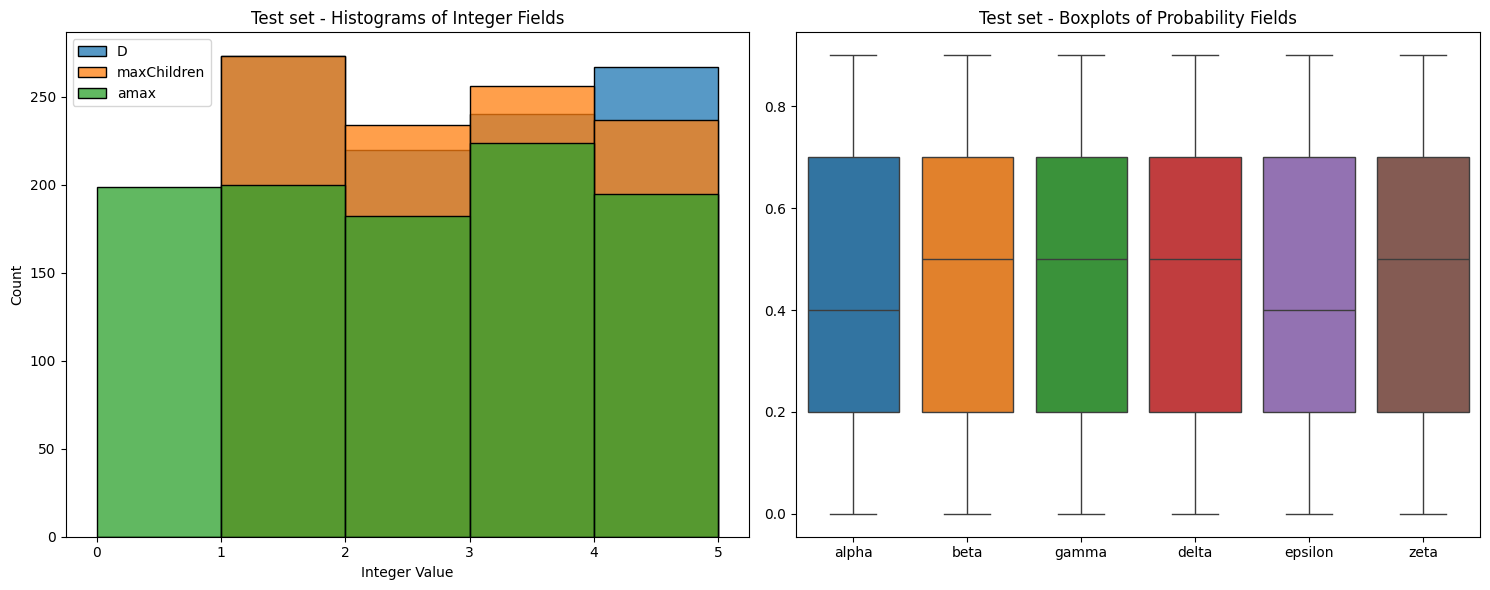

In [21]:
visualize_data(ds_100k_test.to_pandas(), title_prefix="Test set - ")

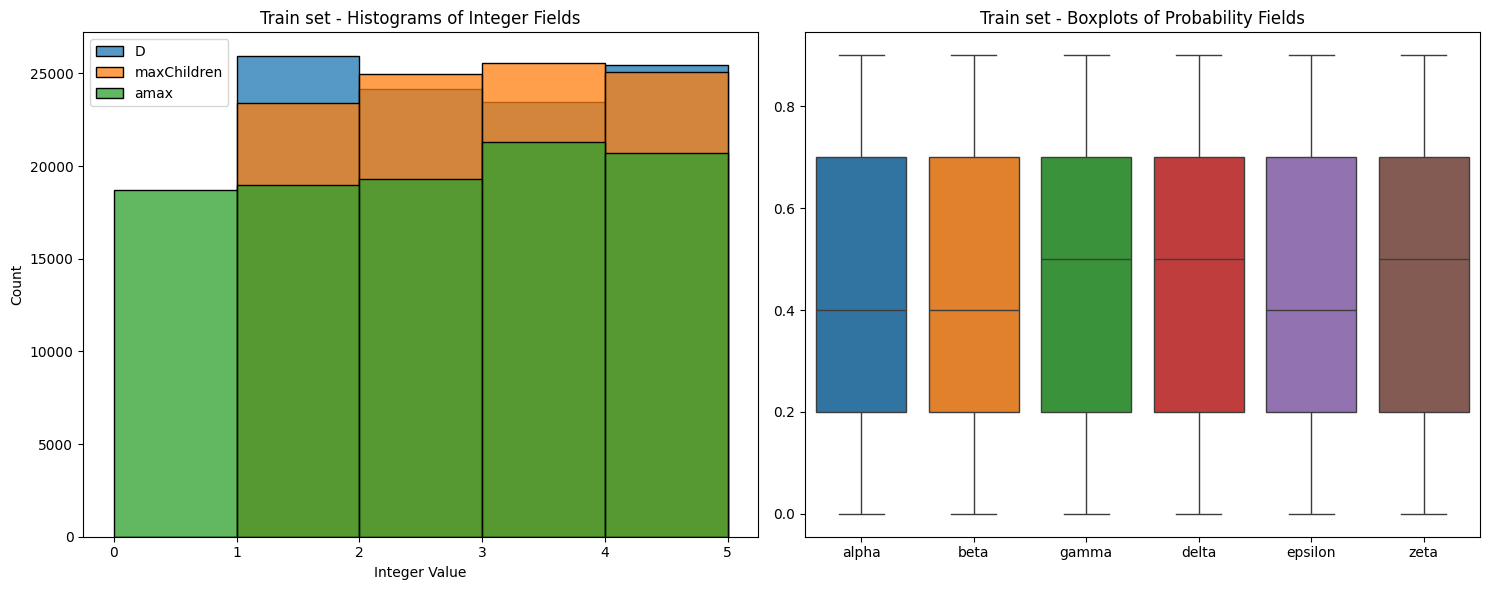

In [22]:
visualize_data(ds_100k_train.to_pandas(), title_prefix="Train set - ")

## Fine-Tuning LoRA adapter for LLama 3.2 1B using Unsloth.ai

In [31]:
import unsloth
from unsloth import FastLanguageModel, is_bfloat16_supported
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from transformers import DataCollatorForSeq2Seq
import numpy as np
from unsloth.chat_templates import train_on_responses_only

def get_model_and_tokenizer(model_id: str, max_seq_length: int, dtype: str=None, load_in_4bit:bool=False):
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = model_id,
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
  )
  return model, tokenizer

def get_unsloth_peft_model(model, lora_config:LoraConfig, random_state:int=None):
  return FastLanguageModel.get_peft_model(
    model,
    use_gradient_checkpointing = "unsloth",
    r = lora_config.r,
    target_modules = lora_config.target_modules,
    lora_alpha = lora_config.lora_alpha,
    lora_dropout = lora_config.lora_dropout,
    bias = lora_config.bias,
    random_state = random_state,
)

def get_unsloth_trainer(model_id, lora_config: LoraConfig, output_dir, train_dataset,
                        eval_dataset, dataset_text_field, compute_metrics, max_seq_length,
                        packing=False, push_to_hub=False, num_train_epochs=1, seed: int=None, batch_size: int = 2,
                        is_completion_only:bool = False, should_validate_train_settings=False,
                        eval_steps=0.05, save_steps=0.05, logging_steps=0.05):

  model, tokenizer = get_model_and_tokenizer(model_id, max_seq_length)
  model = get_unsloth_peft_model(model, lora_config, random_state=seed)

  if should_validate_train_settings:
    validate_train_settings(tokenizer, eval_dataset, train_dataset, dataset_text_field, max_seq_length)

  training_args = SFTConfig(
      max_seq_length = max_seq_length, # Or tokenizer.model_max_length,
      num_train_epochs=num_train_epochs,
      max_steps=-1,
      fp16 = not is_bfloat16_supported(),
      bf16 = is_bfloat16_supported(),
      do_eval = True,
      eval_strategy = "steps",
      eval_steps = eval_steps,
      # Insanely important otherwise all the evaluations are going to OOM the GPU!!!
      eval_accumulation_steps = 10,
      per_device_eval_batch_size=batch_size,
      save_strategy = "steps",
      save_steps = save_steps,
      logging_strategy = "steps",
      logging_steps = logging_steps,
      log_level = "info",
      report_to = "tensorboard",
      optim = "adamw_8bit",
      learning_rate = 2e-4,
      lr_scheduler_type = "linear",
      warmup_steps = 5,
      weight_decay = 0.01,
      gradient_accumulation_steps = 20,
      per_device_train_batch_size = batch_size,
      output_dir = output_dir,
      overwrite_output_dir = True,
      push_to_hub = push_to_hub,
      hub_strategy = "all_checkpoints",
      save_total_limit = None,
      seed = seed,
      dataset_text_field = dataset_text_field,
      packing = packing,
  )

  from functools import partial
  compute_metrics = partial(compute_metrics, packed=packing, tokenizer=tokenizer, is_completion_only=is_completion_only)

  trainer = SFTTrainer(
          model=model,
          args=training_args,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          tokenizer=tokenizer,
          data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
          compute_metrics=compute_metrics,
          # This allows us to reduce the size of the logits stored on the GPU and use a larger eval_accumulation_steps value
          preprocess_logits_for_metrics=lambda logits, labels: torch.argmax(logits, dim=-1),
      )
  if is_completion_only:
    # We don't want to train the model on predicting the instruction but only the response.
    # Unsloth has a handy util to do this,
    # we could have also used DataCollatorForCompletionOnlyLM from the huggingface TRL library to do this
    trainer = train_on_responses_only(
      trainer,
      instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
      response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
    )

  return trainer, training_args, model, tokenizer

#### Training for 140 steps to evaluate convergence

https://huggingface.co/guy-or/formlang-lora-unsloth-2-Llama-3.2-1B-Instruct/tensorboard

In [25]:
output_dir = "./formlang-lora-unsloth-2-Llama-3.2-1B-Instruct"

peft_config = LoraConfig(
          r=64,
          lora_alpha=16,
          lora_dropout=0,
          bias="none",
          task_type="CAUSAL_LM",
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
)
trainer, training_args, model, tokenizer = get_unsloth_trainer(
    "unsloth/Llama-3.2-1B-Instruct",
    peft_config,
    output_dir,
    ds_100k_train,
    ds_100k_test,
    "chat",
    compute_exact_match_metrics,
    4096,
    push_to_hub=True,
    seed=42,
    batch_size=4,
    eval_steps=20
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.3.18 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["chat"] (num_proc=12):   0%|          | 0/98974 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["chat"] (num_proc=12):   0%|          | 0/1000 [00:00<?, ? examples/s]

Using auto half precision backend


In [ ]:
from unsloth import unsloth_train
unsloth_train(trainer)

In [34]:
get_training_table(trainer)

,eval_loss,eval_source_code_exact_match,eval_ast_exact_match,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,grad_norm,learning_rate
0,0.357646,0.162,0.162,198.2605,5.044,1.261,0.016166,20,NaN,NaN,NaN
1,0.163841,0.512,0.512,194.0005,5.155,1.289,0.032331,40,NaN,NaN,NaN
2,0.138484,0.722,0.722,193.4793,5.169,1.292,0.048497,60,NaN,NaN,NaN
3,0.128769,0.832,0.832,193.2084,5.176,1.294,0.064662,80,NaN,NaN,NaN
4,0.117119,0.910,0.910,192.9283,5.183,1.296,0.080828,100,NaN,NaN,NaN
5,0.107709,0.932,0.932,192.7135,5.189,1.297,0.096993,120,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,0.100226,124,0.3494,0.033003,0.00019
7,0.106641,0.956,0.956,192.7913,5.187,1.297,0.113159,140,NaN,NaN,NaN


#### Training for a full Epoch

In [33]:
output_dir = "./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct"
# This time we train with a bigger validation set
perc_2k = 2000 / len(ds_100k_with_prompts)
ds_100k_splits_v2 = ds_100k_with_prompts.train_test_split(test_size=perc_2k, shuffle=True, seed=42)
ds_100k_train_v2, ds_100k_test_v2 = ds_100k_splits_v2["train"], ds_100k_splits_v2["test"]
peft_config = LoraConfig(
          r=64,
          lora_alpha=16,
          lora_dropout=0,
          bias="none",
          task_type="CAUSAL_LM",
          target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
)
trainer, training_args, model, tokenizer = get_unsloth_trainer(
    "unsloth/Llama-3.2-1B-Instruct",
    peft_config,
    output_dir,
    ds_100k_train_v2,
    ds_100k_test_v2,
    "chat",
    compute_exact_match_metrics,
    4096,
    push_to_hub=True,
    seed=42,
    batch_size=8,
    eval_steps=100,
    save_steps=100,
    logging_steps=100
)

==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2025.3.18 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["chat"] (num_proc=12):   0%|          | 0/97974 [00:00<?, ? examples/s]

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["chat"] (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Using auto half precision backend


In [34]:
from unsloth import unsloth_train
train_result = unsloth_train(trainer)

The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: alpha, chat, maxChildren, originalFormAst, Index, zeta, inferencePrompt, epsilon, removedNodeContextEnglish, gamma, userPrompt, amax, modifiedFormCode, originalFormCode, removedNodeEnglish, delta, D, beta. If alpha, chat, maxChildren, originalFormAst, Index, zeta, inferencePrompt, epsilon, removedNodeContextEnglish, gamma, userPrompt, amax, modifiedFormCode, originalFormCode, removedNodeEnglish, delta, D, beta are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 97,974 | Num Epochs = 1 | Total steps = 612
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 20
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 20 x 1) = 160
 "-____-"     Trainable parameters = 45,088,768/1,280,903,168 (3.52% 

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,Source Code Exact Match,Ast Exact Match
100,0.405700,0.120588,0.891500,0.891500
200,0.114900,0.104189,0.971500,0.971500
300,0.110800,0.102686,0.982000,0.982000
400,0.109300,0.101912,0.985500,0.985500
500,0.109000,0.101396,0.988000,0.988000
600,0.107900,0.101033,0.989500,0.989500


The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: alpha, chat, maxChildren, originalFormAst, Index, zeta, inferencePrompt, epsilon, removedNodeContextEnglish, gamma, userPrompt, amax, modifiedFormCode, originalFormCode, removedNodeEnglish, delta, D, beta. If alpha, chat, maxChildren, originalFormAst, Index, zeta, inferencePrompt, epsilon, removedNodeContextEnglish, gamma, userPrompt, amax, modifiedFormCode, originalFormCode, removedNodeEnglish, delta, D, beta are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:19<00:00, 100.24it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/checkpoint-100
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:19<00:00, 103.20it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:19<00:00, 102.35it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/checkpoint-300
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:18<00:00, 105.62it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/checkpoint-400
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:16<00:00, 119.16it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/checkpoint-500
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:17<00:00, 114.28it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/checkpoint-600
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_positio

In [35]:
import torch

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
print(f"{train_result.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(train_result.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")

6413.4275 seconds used for training.
106.89 minutes used for training.
Peak reserved memory = 27.029 GB.


In [36]:
train_result

TrainOutput(global_step=612, training_loss=0.15866414199467577, metrics={'train_runtime': 6413.4275, 'train_samples_per_second': 15.276, 'train_steps_per_second': 0.095, 'total_flos': 6.367192138924032e+17, 'train_loss': 0.15866414199467577})

In [37]:
get_training_table(trainer)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_source_code_exact_match,eval_ast_exact_match,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4057,0.063290,0.000169,0.163305,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.163305,100,0.120588,0.8915,0.8915,165.9365,12.053,1.507,NaN,NaN,NaN,NaN,NaN
2,0.1149,0.024223,0.000136,0.326611,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.326611,200,0.104189,0.9715,0.9715,160.8593,12.433,1.554,NaN,NaN,NaN,NaN,NaN
4,0.1108,0.025034,0.000103,0.489916,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.489916,300,0.102686,0.9820,0.9820,160.3196,12.475,1.559,NaN,NaN,NaN,NaN,NaN
6,0.1093,0.023527,0.000070,0.653221,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.653221,400,0.101912,0.9855,0.9855,159.6588,12.527,1.566,NaN,NaN,NaN,NaN,NaN
8,0.1090,0.020902,0.000037,0.816526,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.816526,500,0.101396,0.9880,0.9880,153.8089,13.003,1.625,NaN,NaN,NaN,NaN,NaN


In [38]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: alpha, chat, maxChildren, originalFormAst, Index, zeta, inferencePrompt, epsilon, removedNodeContextEnglish, gamma, userPrompt, amax, modifiedFormCode, originalFormCode, removedNodeEnglish, delta, D, beta. If alpha, chat, maxChildren, originalFormAst, Index, zeta, inferencePrompt, epsilon, removedNodeContextEnglish, gamma, userPrompt, amax, modifiedFormCode, originalFormCode, removedNodeEnglish, delta, D, beta are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


Logits shape: (2000, 2555)
Labels shape: (2000, 2555)
Predictions shape: (2000, 2555)


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

Computing AST - References: 100%|██████████| 2000/2000 [00:17<00:00, 116.94it/s]


Map (num_proc=12):   0%|          | 0/2000 [00:00<?, ? examples/s]

{'eval_loss': 0.10102447867393494,
 'eval_source_code_exact_match': 0.99,
 'eval_ast_exact_match': 0.99,
 'eval_runtime': 153.7183,
 'eval_samples_per_second': 13.011,
 'eval_steps_per_second': 1.626}

In [39]:
get_training_table(trainer)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_source_code_exact_match,eval_ast_exact_match,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4057,0.063290,0.000169,0.163305,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.163305,100,0.120588,0.8915,0.8915,165.9365,12.053,1.507,NaN,NaN,NaN,NaN,NaN
2,0.1149,0.024223,0.000136,0.326611,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.326611,200,0.104189,0.9715,0.9715,160.8593,12.433,1.554,NaN,NaN,NaN,NaN,NaN
4,0.1108,0.025034,0.000103,0.489916,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.489916,300,0.102686,0.9820,0.9820,160.3196,12.475,1.559,NaN,NaN,NaN,NaN,NaN
6,0.1093,0.023527,0.000070,0.653221,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.653221,400,0.101912,0.9855,0.9855,159.6588,12.527,1.566,NaN,NaN,NaN,NaN,NaN
8,0.1090,0.020902,0.000037,0.816526,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.816526,500,0.101396,0.9880,0.9880,153.8089,13.003,1.625,NaN,NaN,NaN,NaN,NaN


In [40]:
trainer.push_to_hub()

Saving model checkpoint to ./formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--Llama-3.2-1B-Instruct/snapshots/9b58d4a36161a1e49ecf0a69d20b2736fef8e438/config.json
Model config LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 

  0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/90.2M [00:00<?, ?B/s]

(…)t.tfevents.1742836428.9c28fcf64dfd.343.1:   0%|          | 0.00/485 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/guy-or/formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct/commit/07dafe45fb1b48ec7697cd2a63af03c800370cf5', commit_message='End of training', commit_description='', oid='07dafe45fb1b48ec7697cd2a63af03c800370cf5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/guy-or/formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct', endpoint='https://huggingface.co', repo_type='model', repo_id='guy-or/formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct'), pr_revision=None, pr_num=None)

In [41]:
get_training_table(trainer).to_csv("training_table.csv")

In [ ]:
model, tok_for_model = FastLanguageModel.from_pretrained("guy-or/formlang-lora-unsloth-1ep-Llama-3.2-1B-Instruct")

In [ ]:
FastLanguageModel.for_inference(model)

In [47]:
def trytry(model, tokenizer):
  messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,"},
]
  inputs = tokenizer.apply_chat_template(
      messages,
      tokenize = True,
      add_generation_prompt = True, # Must add for generation
      return_tensors = "pt",
  ).to("cuda")

  outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                          temperature = 1.5, min_p = 0.1)
  return tokenizer.batch_decode(outputs)
trytry(model, tok_for_model)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 24 Mar 2025\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nContinue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nThe given sequence is a Fibonacci sequence, where each number is the sum of the two preceding numbers.\n\nThe correct next term in the sequence would be: 13\n\nTo generate the next term, we add the last two numbers in the sequence:\n1 + 1 = 2\n2 + 3 = 5']

# Citations

```bibtex
@article{EVTIKHIEV2023111741,
title = {Out of the BLEU: How should we assess quality of the Code Generation models?},
journal = {Journal of Systems and Software},
volume = {203},
pages = {111741},
year = {2023},
issn = {0164-1212},
doi = {https://doi.org/10.1016/j.jss.2023.111741},
url = {https://www.sciencedirect.com/science/article/pii/S016412122300136X},
author = {Mikhail Evtikhiev and Egor Bogomolov and Yaroslav Sokolov and Timofey Bryksin},
keywords = {Code generation, Metrics, Neural networks, Code similarity},
abstract = {In recent years, researchers have created and introduced a significant number of various code generation models. As human evaluation of every new model version is unfeasible, the community adopted automatic evaluation metrics such as BLEU to approximate the results of human judgement. These metrics originate from the machine translation domain and it is unclear whether they are applicable for the code generation tasks and how well they agree with the human evaluation on this task. There are also other metrics, CodeBLEU and RUBY, developed to estimate the similarity of code, that take into account the properties of source code. However, for these metrics there are hardly any studies on their agreement with the human evaluation. Despite all that, minimal differences in the metric scores have been used in recent papers to claim superiority of some code generation models over the others. In this paper, we present a study on the applicability of six metrics—BLEU, ROUGE-L, METEOR, ChrF, CodeBLEU, and RUBY—for evaluation of code generation models. We conduct a study on two different code generation datasets and use human annotators to assess the quality of all models run on these datasets. The results indicate that for the CoNaLa dataset of Python one-liners, none of the metrics can correctly emulate human judgement on which model is better with >95% certainty if the difference in model scores is less than 5 points. For the HearthStone dataset, which consists of classes of a particular structure, a difference in model scores of at least 2 points is enough to claim the superiority of one model over the other. Our findings suggest that the ChrF metric is a better fit for the evaluation of code generation models than the commonly used BLEU and CodeBLEU. Yet, finding a metric for code generation that closely agrees with humans requires additional work.}
}
```

# Appendix A - Notebook Setup

## About the FormLang DSL and its codebase

The FormLang DSL is implemented using [Langium](https://langium.org/). Langium is a toolkit written in TypeScript that allows language engineers to create DSLs and quickly iterate over their development lifecycle.

Some of the many features offered by Langium are:

* Parser generation - Langium leverages [Chevrotain](https://chevrotain.io/docs/) to create a fast parser that can parse the DSL code to AST.
* TypeScript AST nodes generation - Langium automatically generates TS types that represent the AST of the language.
* Simplified Validation rules - Langium has built in support for writing and executing validation rules with built in error reporting.
* Language Server Protocol support - Langium implements the LSP protocol which allows code completion and syntax highlighting in many IDEs such as VSCode.

Since we are using Langium to parse the FormLang DSL, some of this project tooling and algorithms are written in TypeScript.

To call our TypeScript code from Python I've implemented a local REST-API server that implements some functions we require (e.g for parsing FormLang code to AST and generating forms).

### Codebase

The entire codebase is hosted in Github at [FormLang](https://github.com/guyo13/Form-Lang).

### Running from Colab

#### Installing Dependencies

In [ ]:
!npm install -g pnpm && npm install -g bun@latest && npm install -g corepack@latest && bun -v

In [ ]:
!pip install --quiet datasets evaluate bitsandbytes unsloth optimum-quanto unsloth_zoo

In [ ]:
!pip install flash-attn --quiet --no-build-isolation

#### Clone the FormLang repo and install its dependencies

In [ ]:
!rm -rf Form-Lang && git clone https://github.com/guyo13/Form-Lang.git

#### Install project dependencies and build

In [ ]:
!cd Form-Lang && corepack install && corepack pnpm install && corepack pnpm run gb && cd ml && pnpm install

#### Run the FormLang HTTP API server

The HTTP API server can be run directly from the notebook by using the below code (requires `bun` and other previously installed dependencies). Simply uncomment the `http_server = run_js_with_bun("bun_cluster.ts", "Form-Lang/ml")` line below.

In [6]:
from subprocess import Popen, PIPE
import sys

def run_js_with_bun(js_file, cwd=None):
  """
  Runs a JavaScript file using Bun as a subprocess.

  Args:
    js_file: The path to the JavaScript file.
    cwd: The working directory for the child process.
         If None, the current working directory is used.
  """
  try:
    # Execute the JavaScript file using Bun with specified working directory
    process = Popen(['bun', js_file], stdout=PIPE, cwd=cwd)
    return process

  except FileNotFoundError:
    print("Error: Bun not found. Please ensure Bun is installed and in your PATH.")
  except Exception as e:
    import traceback
    traceback.print_exc()
    print("An unexpected error occurred:", e)

# Uncomment to start server
#http_server = run_js_with_bun("bun_cluster.ts", "Form-Lang/ml")
#http_server

##### Testing the connection to the HTTP server

In [7]:
!curl -d '{"sourceCode": "component hey{} form helloWorld {comp hey}"}' -H "content-type: application/json" "http://localhost:3000/compute/ast"

curl: (7) Failed to connect to localhost port 3000 after 0 ms: Connection refused


## Project imports

In [8]:
import unsloth
import asyncio
import time
import re
import functools
import json
import multiprocessing
from pprint import pprint
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, GenerationConfig, QuantizedCacheConfig
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig
from datasets import Dataset, load_dataset
from huggingface_hub import login
from tqdm.notebook import trange, tqdm
import evaluate
import pandas as pd
import numpy as np
import requests
import torch
import matplotlib.pyplot as plt
import seaborn as sns

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Login to Huggingface Hub

In [9]:
from huggingface_hub import login

login()

## Helper functions

### FormLang Api client

In order to check the model's output we will need to parse the output FormLang code and check it for errors. We will also use the AST to compute performance metrics.

The `get_ast` function will be used to send FormLang source code to our local HTTP API for parsing.  

The `generate_random_forms` is used to invoke the random forms generator algorithm used in the begining of the notebook.

In [10]:
import requests
import logging
import sys

API_CLIENT_LOGGER = logging.getLogger("api_client")
API_CLIENT_LOGGER.setLevel(logging.ERROR)
detailed_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(module)s - %(funcName)s - %(lineno)d - %(message)s')
detailed_handler = logging.StreamHandler(sys.stderr)
detailed_handler.setFormatter(detailed_formatter)
API_CLIENT_LOGGER.addHandler(detailed_handler)



def get_ast(code, shouldCheckErrors=False):
    result = requests.post("http://localhost:3000/compute/ast", json={"sourceCode": code, "shouldCheckErrors":shouldCheckErrors}).json()
    if not result["status"] == "ok":
        API_CLIENT_LOGGER.warning("get_ast Failed error response.", extra={"response": result})
        return {"ast": "{}"}
    return result["result"]

def generate_random_forms(count, form_components_code, field_components_code, hyperparams):
    """
    Sends a POST request to /compute/random_forms to generate random forms.

    Args:
        count (int): The number of forms to generate.
        form_components_code (str): The code for form components.
        field_components_code (str): The code for field components.
        hyperparams (dict): Hyperparameters for the form generation.

    Returns:
        dict: The result of the random form generation, or None if an error occurred.
    """
    try:
        response = requests.post(
            "http://localhost:3000/compute/random_forms",
            json={
                "count": count,
                "formComponentsCode": form_components_code,
                "fieldComponentsCode": field_components_code,
                "hyperparams": hyperparams,
            },
        )
        response.raise_for_status()
        result = response.json()
        if result["status"] == "ok":
            return result["result"]
        else:
            API_CLIENT_LOGGER.error("generate_random_forms Failed error response.", extra={"response": result})
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error during request: {e}")
        return None
    except ValueError as e: #if the json cannot be decoded.
        print(f"Error decoding JSON: {e}")
        return None

### Visualization utils

The `visualize_data` takes in a Dataframe that contains the form generator hyperparameters as columns and plots a histogram of the integer hyperparams and a boxplot of the probability hyperparams.

In [11]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_data(df, title_prefix: str = ""):
    """Creates histograms and boxplots side by side."""

    probability_fields = ["alpha", "beta", "gamma", "delta", "epsilon", "zeta"]
    integer_fields = ["D", "maxChildren", "amax"]

    plt.figure(figsize=(15, 6))

    # Histograms for integer fields with consistent bins
    plt.subplot(1, 2, 1)
    all_integer_values = pd.concat([df[field].dropna() for field in integer_fields])
    bins = range(int(all_integer_values.min()), int(all_integer_values.max()) + 2)

    for field in integer_fields:
        sns.histplot(df[field].dropna(), bins=bins, label=field)
    plt.title(f"{title_prefix}Histograms of Integer Fields")
    plt.xlabel("Integer Value")
    plt.legend(loc='upper left')

    # Boxplots for probability fields
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[probability_fields])
    plt.title(f"{title_prefix}Boxplots of Probability Fields")

    plt.tight_layout()
    plt.show()

The `side_by_side_diff` displays an HTML diff view of two strings side by side.

In [12]:
import difflib
from IPython.display import HTML, display

def side_by_side_diff(text1, text2):
    """
    Displays a side-by-side diff of two strings in Jupyter Notebook.
    """
    d = difflib.HtmlDiff()
    diff_html = d.make_file(text1.splitlines(), text2.splitlines())
    display(HTML(diff_html))


### Print training data

The `get_training_table` accepts a huggingface Trainer object and returns its logs inside a DataFrame by reading its internal state.

The `load_and_print_training_table_from_hub` does the same but given a Huggingface repo of a trained model, useful on subsequent notebook runs after the Trainer state is lost.  

In [13]:
import pandas as pd

def get_training_table(trainer):
    """Prints the training metrics table from the trainer's log history."""
    log_history = trainer.state.log_history
    df = pd.DataFrame(log_history)
    return df


In [13]:
import json
from huggingface_hub import hf_hub_download
import pandas as pd

def load_and_print_training_table_from_hub(repo_id):
    """Loads the training log history from the Hugging Face Hub and prints it."""
    try:
        # Download the training_args.json file
        file_path = hf_hub_download(repo_id=repo_id, filename="training_args.json")

        # Load the JSON data
        with open(file_path, "r") as f:
            training_args = json.load(f)

        # Extract the log_history
        log_history = training_args.get("log_history", [])

        if log_history:
            # Print using pandas
            df = pd.DataFrame(log_history)
            print(df)
        else:
            print("No log history found in the training_args.json file.")

    except Exception as e:
        print(f"An error occurred: {e}")